In [1]:
#Importation des bibliothèques
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#Implémentation du modèle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import LabelEncoder
#Normalissation
from sklearn.preprocessing import MinMaxScaler

In [18]:
#Chargement du dataset
df = pd.read_excel('Ecriturecompte.xlsx')

In [19]:
df.head(5)

,PFE,Écriture comptable article,32,Unnamed: 3,Unnamed: 4,Unnamed: 5
0,NaN,NaN,NaN,NaN,NaN,NaN
1,N° séquence,N° article,Date comptabilisation,Type écriture,Quantité,Type document
2,1,PI106,2021-04-01,Vente,-18.3,Expédition vente
3,2,70298,2021-04-01,Vente,-324.29,Expédition vente
4,3,RO047,2021-04-01,Vente,-204,Expédition vente


In [20]:
df = df.iloc[2:]
# Réinitialiser l'index
df = df.reset_index(drop=True)
df.head()
#Renommer les colonnes
df=df.rename(columns={f'{df.columns.values[1]}': 'PRODUIT'})
df=df.rename(columns={f'{df.columns.values[2]}': 'PERIODE'})
df=df.rename(columns={f'{df.columns.values[4]}': 'QUANTITE'})
df['QUANTITE']=df['QUANTITE'].astype(float)
df.head(5)

,PFE,PRODUIT,PERIODE,Unnamed: 3,QUANTITE,Unnamed: 5
0,1,PI106,2021-04-01,Vente,-18.30,Expédition vente
1,2,70298,2021-04-01,Vente,-324.29,Expédition vente
2,3,RO047,2021-04-01,Vente,-204.00,Expédition vente
3,4,RO060,2021-04-01,Vente,-150.00,Expédition vente
4,5,70223,2021-04-01,Vente,-109.89,Expédition vente


In [21]:
#Sélection des colones
df=df[['PRODUIT','PERIODE','QUANTITE']]
df.head(5)

,PRODUIT,PERIODE,QUANTITE
0,PI106,2021-04-01,-18.30
1,70298,2021-04-01,-324.29
2,RO047,2021-04-01,-204.00
3,RO060,2021-04-01,-150.00
4,70223,2021-04-01,-109.89


In [22]:
#Rendre les quantité positives
df['QUANTITE'] = np.abs(df['QUANTITE'])
df.head(5)

,PRODUIT,PERIODE,QUANTITE
0,PI106,2021-04-01,18.30
1,70298,2021-04-01,324.29
2,RO047,2021-04-01,204.00
3,RO060,2021-04-01,150.00
4,70223,2021-04-01,109.89


In [23]:
df.head(5)

,PRODUIT,PERIODE,QUANTITE
0,PI106,2021-04-01,18.30
1,70298,2021-04-01,324.29
2,RO047,2021-04-01,204.00
3,RO060,2021-04-01,150.00
4,70223,2021-04-01,109.89


### Sélection de 5 Produits Différents

In [26]:
top_5_products = df.groupby('PRODUIT')['QUANTITE'].sum().nlargest(5).index
df_filtered = df[df['PRODUIT'].isin(top_5_products)]

### Préparer les Données pour ces 5 Produits

In [27]:
# Étape 1 : Vérifier les doublons
duplicates = df_filtered[df_filtered.duplicated(subset=['PERIODE', 'PRODUIT'], keep=False)]
print(f"Doublons trouvés :\n{duplicates}")

# Étape 2 : Gérer les doublons (exemple : somme des quantités)
df_filtered = df_filtered.groupby(['PERIODE', 'PRODUIT'], as_index=False).sum()

# Étape 3 : Pivotement
df_filtered_pivot = df_filtered.pivot(index='PERIODE', columns='PRODUIT', values='QUANTITE')
df_filtered_pivot = df_filtered_pivot.fillna(0)

# Étape 4 : Vérification
print(df_filtered_pivot.head())


Doublons trouvés :
       PRODUIT     PERIODE  QUANTITE
1582     70312  2021-04-09     136.0
1600     70312  2021-04-09      13.6
1602     70312  2021-04-09     544.0
1603     70312  2021-04-09     136.0
1611     70312  2021-04-09      68.0
...        ...         ...       ...
180037   70315  2023-09-23      30.0
180049   70315  2023-09-23      60.0
180063   70763  2023-09-23    1000.0
180064   70315  2024-10-28    7000.0
180065   70315  2024-10-28    3500.0

[16349 rows x 3 columns]
PRODUIT       70312  70315  70762  70763    RO089
PERIODE                                          
2021-04-09  20332.0    0.0    0.0    0.0   2040.0
2021-04-10   8064.8    0.0    0.0    0.0  23092.8
2021-04-12      0.0    0.0    0.0    0.0   4828.0
2021-04-13      0.0    0.0    0.0    0.0    176.8
2021-04-14     13.6    0.0    0.0    0.0      0.0


In [30]:
# Création de la série temporelle globale (somme des ventes des 5 produits)
global_series = df_filtered_pivot.sum(axis=1)

## 1- Visualisation de la série temporelle globale

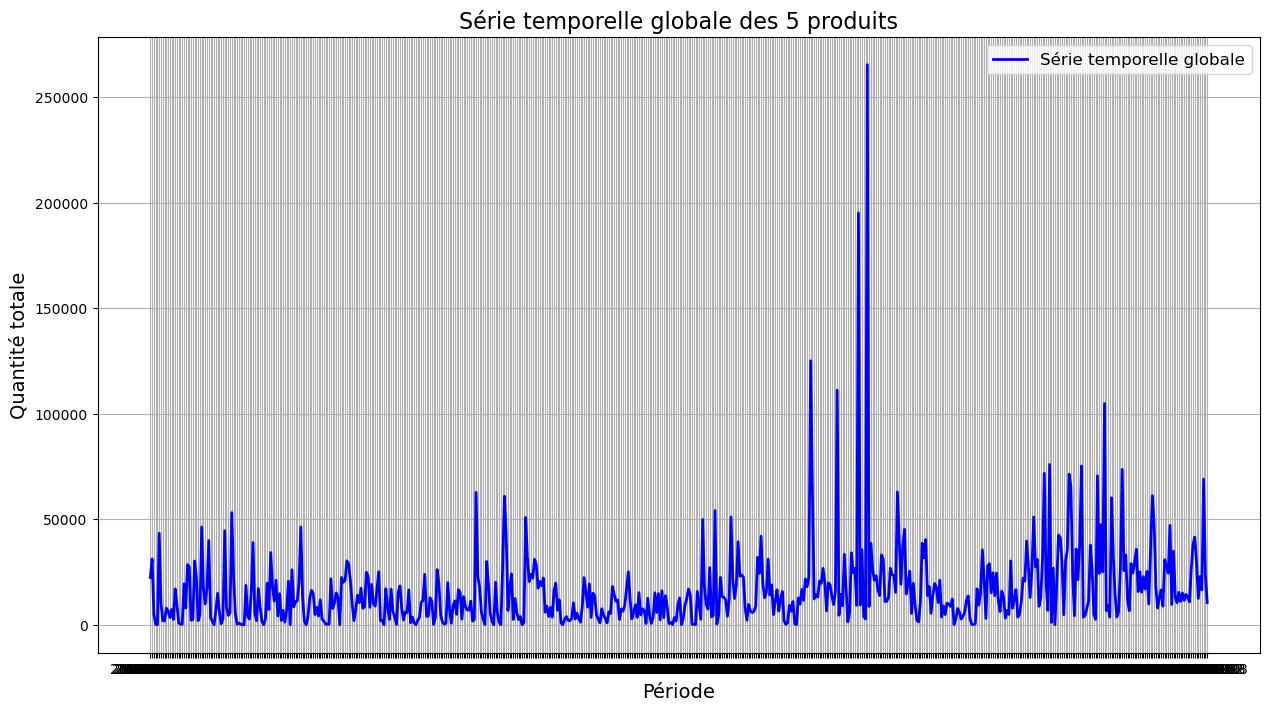

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 8))
plt.plot(global_series, label="Série temporelle globale", color="blue", linewidth=2)
plt.title("Série temporelle globale des 5 produits", fontsize=16)
plt.xlabel("Période", fontsize=14)
plt.ylabel("Quantité totale", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

## 2-Décomposition de la série temporelle

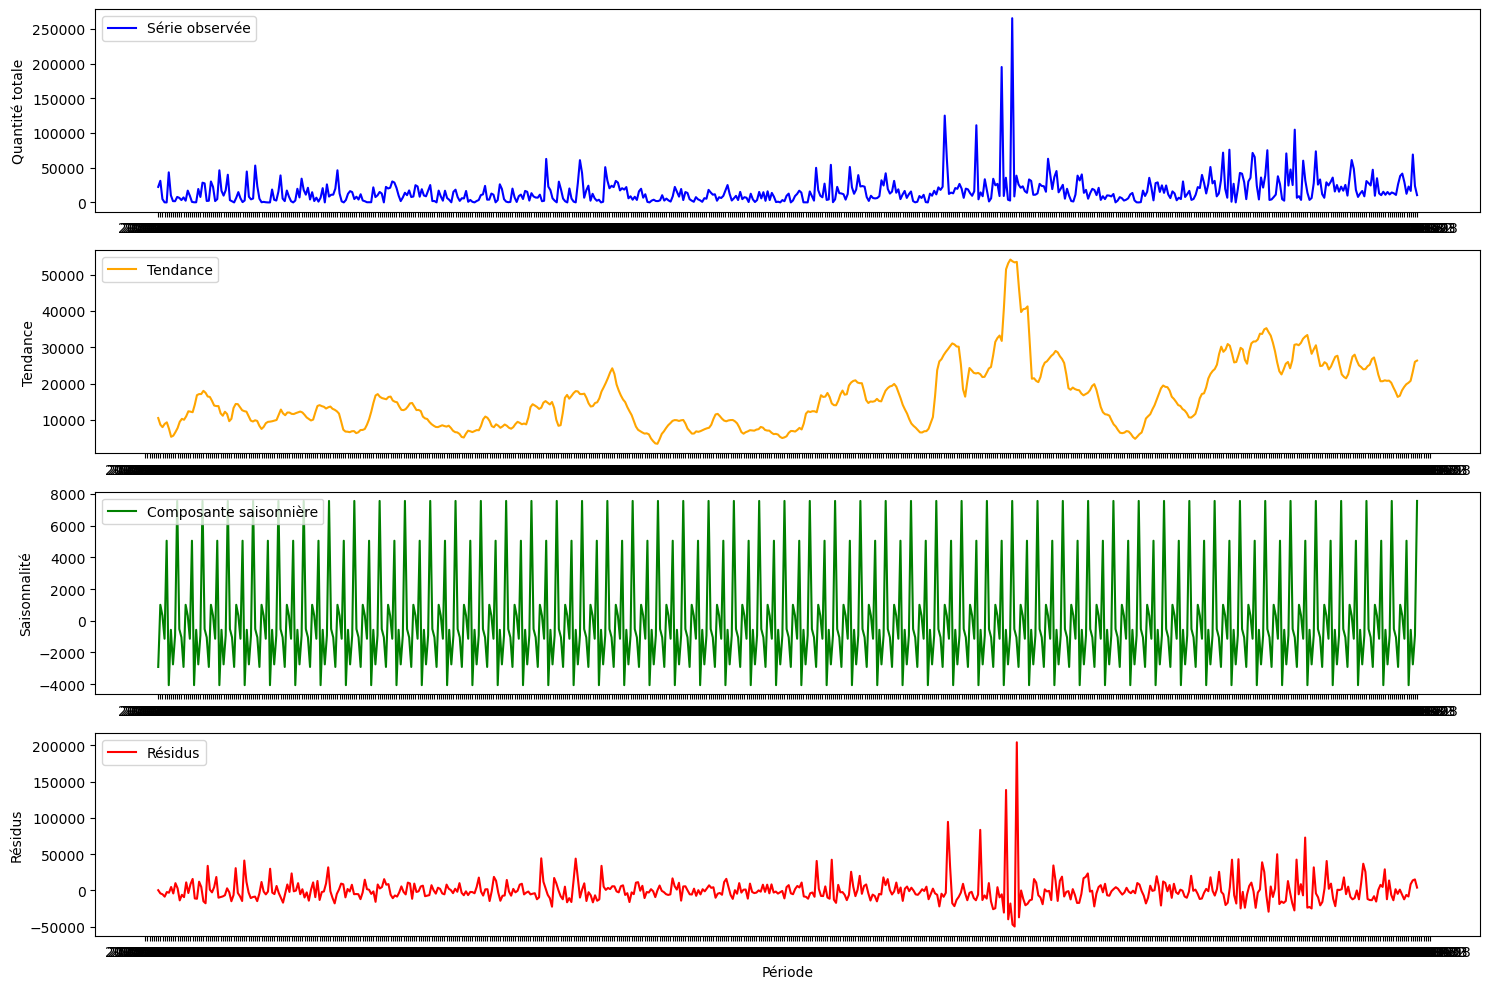

In [33]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Décomposition de la série temporelle globale
decomposition = seasonal_decompose(global_series, model='additive', period=12)  # Ajustez `period` selon vos données

# Visualisation des composants
plt.figure(figsize=(15, 10))

# Série observée
plt.subplot(4, 1, 1)
plt.plot(decomposition.observed, label="Série observée", color="blue")
plt.legend(loc='upper left')
plt.ylabel("Quantité totale")

# Tendance
plt.subplot(4, 1, 2)
plt.plot(decomposition.trend, label="Tendance", color="orange")
plt.legend(loc='upper left')
plt.ylabel("Tendance")

# Saisonnière
plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal, label="Composante saisonnière", color="green")
plt.legend(loc='upper left')
plt.ylabel("Saisonnalité")

# Résiduel
plt.subplot(4, 1, 4)
plt.plot(decomposition.resid, label="Résidus", color="red")
plt.legend(loc='upper left')
plt.ylabel("Résidus")
plt.xlabel("Période")

plt.tight_layout()
plt.show()


## 3- Tester de Stationnarité de la série globale et les résidus

In [36]:
from statsmodels.tsa.stattools import adfuller, kpss

# Fonction pour interpréter le test ADF
def test_adf(series):
    result = adfuller(series, autolag='AIC')
    print("Test de Dickey-Fuller Augmenté (ADF):")
    print(f"Statistique de test : {result[0]:.4f}")
    print(f"P-valeur : {result[1]:.4f}")
    print("Valeurs critiques :")
    for key, value in result[4].items():
        print(f"   {key}: {value:.4f}")
    if result[1] <= 0.05:
        print("La série est stationnaire (rejette H0).")
    else:
        print("La série n'est pas stationnaire (accepte H0).")

# Fonction pour interpréter le test KPSS
def test_kpss(series, regression='c'):
    result = kpss(series, regression=regression, nlags="auto")
    print("Test KPSS:")
    print(f"Statistique de test : {result[0]:.4f}")
    print(f"P-valeur : {result[1]:.4f}")
    print("Valeurs critiques :")
    for key, value in result[3].items():
        print(f"   {key}: {value:.4f}")
    if result[1] <= 0.05:
        print("La série n'est pas stationnaire (rejette H0).")
    else:
        print("La série est stationnaire (accepte H0).")


In [41]:
# Différenciation de la série globale
global_series_diff = global_series.diff().dropna()

# Vérifiez la stationnarité à nouveau après différenciation
print("\nAnalyse après différenciation :")
test_adf(global_series_diff)
test_kpss(global_series_diff)



Analyse après différenciation :
Test de Dickey-Fuller Augmenté (ADF):
Statistique de test : -11.5749
P-valeur : 0.0000
Valeurs critiques :
   1%: -3.4417
   5%: -2.8665
   10%: -2.5694
La série est stationnaire (rejette H0).
Test KPSS:
Statistique de test : 0.0423
P-valeur : 0.1000
Valeurs critiques :
   10%: 0.3470
   5%: 0.4630
   2.5%: 0.5740
   1%: 0.7390
La série est stationnaire (accepte H0).


C:\Users\User\AppData\Local\Temp\ipykernel_17288\3832844533.py:19: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression, nlags="auto")


## CONCLUSION 

#### Puisque la série est stationnaire mais présente des tendances et de la saisonnalité, vous pouvez maintenant passer à 
#### l'étape suivante, qui consiste à appliquer un modèle SARIMA (Seasonal ARIMA) pour capturer à la fois la tendance et la saisonnalité. 
#### Le modèle SARIMA est spécialement conçu pour gérer les séries temporelles qui ont une composante saisonnière.

In [45]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd

# Paramètres SARIMA
p, d, q = 1, 1, 1  # Paramètres ARIMA
P, D, Q, m = 1, 1, 1, 12  # Paramètres saisonniers (m=12 pour mensuel)

# Dictionnaire pour stocker les résultats
models = {}

# Boucle pour chaque produit
for produit in df_filtered_pivot.columns:
    try:
        # Vérification si le produit a des données valides
        if df_filtered_pivot[produit].isnull().sum() > 0:
            print(f"Le produit {produit} contient des valeurs manquantes et ne sera pas modélisé.")
            continue  # Passer au produit suivant si des valeurs manquent

        # Modèle SARIMA pour chaque produit
        model_sarima = SARIMAX(df_filtered_pivot[produit], order=(p, d, q), seasonal_order=(P, D, Q, m))
        results_sarima = model_sarima.fit()

        # Stocker les résultats dans un dictionnaire
        models[produit] = results_sarima

        # Afficher les résultats
        print(f"Produit: {produit}")
        print(results_sarima.summary())

        # Analyse des résidus
        residuals = results_sarima.resid
        print(f"Autocorrélation des résidus pour {produit}: {residuals.autocorr()}")
        # Tester les résidus pour la normalité et l'hétéroscédasticité
        print(f"Jarque-Bera Test: {results_sarima.test_normality()}")
        print(f"Test de Breusch-Pagan pour hétéroscédasticité: {results_sarima.test_heteroscedasticity()}")

    except Exception as e:
        print(f"Erreur avec le produit {produit}: {e}")


C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Produit: 70312
                                     SARIMAX Results                                      
Dep. Variable:                              70312   No. Observations:                  598
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -6239.534
Date:                            Thu, 21 Nov 2024   AIC                          12489.068
Time:                                    23:19:15   BIC                          12510.926
Sample:                                         0   HQIC                         12497.586
                                            - 598                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3656      0.078      4.712      0.000       0.214       0.518
ma.L1         -0.983

C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Produit: 70315
                                     SARIMAX Results                                      
Dep. Variable:                              70315   No. Observations:                  598
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -5672.414
Date:                            Thu, 21 Nov 2024   AIC                          11354.829
Time:                                    23:19:22   BIC                          11376.687
Sample:                                         0   HQIC                         11363.347
                                            - 598                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2729      0.036      7.632      0.000       0.203       0.343
ma.L1         -0.907

C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Produit: 70762
                                     SARIMAX Results                                      
Dep. Variable:                              70762   No. Observations:                  598
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -6114.838
Date:                            Thu, 21 Nov 2024   AIC                          12239.676
Time:                                    23:19:29   BIC                          12261.534
Sample:                                         0   HQIC                         12248.194
                                            - 598                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0043      0.079      0.054      0.957      -0.151       0.159
ma.L1         -0.999

C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1420: RuntimeWarning: divide by zero encountered in divide
  test_statistic = numer_squared_sum / denom_squared_sum
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Produit: 70763
                                     SARIMAX Results                                      
Dep. Variable:                              70763   No. Observations:                  598
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -6216.315
Date:                            Thu, 21 Nov 2024   AIC                          12442.630
Time:                                    23:19:34   BIC                          12464.488
Sample:                                         0   HQIC                         12451.148
                                            - 598                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0812      0.026      3.141      0.002       0.031       0.132
ma.L1         -0.999

C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1420: RuntimeWarning: divide by zero encountered in divide
  test_statistic = numer_squared_sum / denom_squared_sum
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Produit: RO089
                                     SARIMAX Results                                      
Dep. Variable:                              RO089   No. Observations:                  598
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -5785.518
Date:                            Thu, 21 Nov 2024   AIC                          11581.036
Time:                                    23:19:41   BIC                          11602.894
Sample:                                         0   HQIC                         11589.555
                                            - 598                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4605      0.025     18.570      0.000       0.412       0.509
ma.L1         -1.000

In [46]:
df_filtered_pivot

PRODUIT,70312,70315,70762,70763,RO089
PERIODE,,,,,
2021-04-09,20332.0,0.0,0.0,0.0,2040.0
2021-04-10,8064.8,0.0,0.0,0.0,23092.8
2021-04-12,0.0,0.0,0.0,0.0,4828.0
2021-04-13,0.0,0.0,0.0,0.0,176.8
2021-04-14,13.6,0.0,0.0,0.0,0.0
...,...,...,...,...,...
2023-09-20,12403.2,5590.0,4880.0,0.0,0.0
2023-09-21,11396.8,4060.0,1120.0,0.0,0.0
2023-09-22,4161.6,5420.0,22080.0,37320.0,0.0


C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


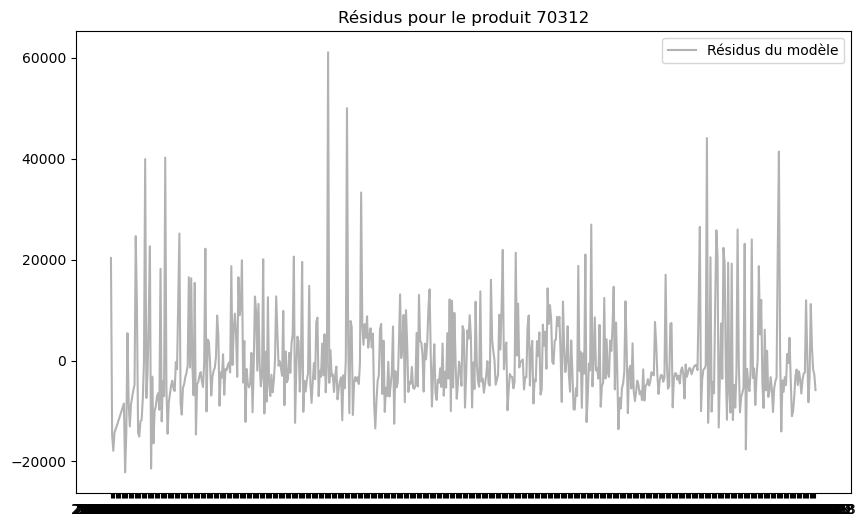

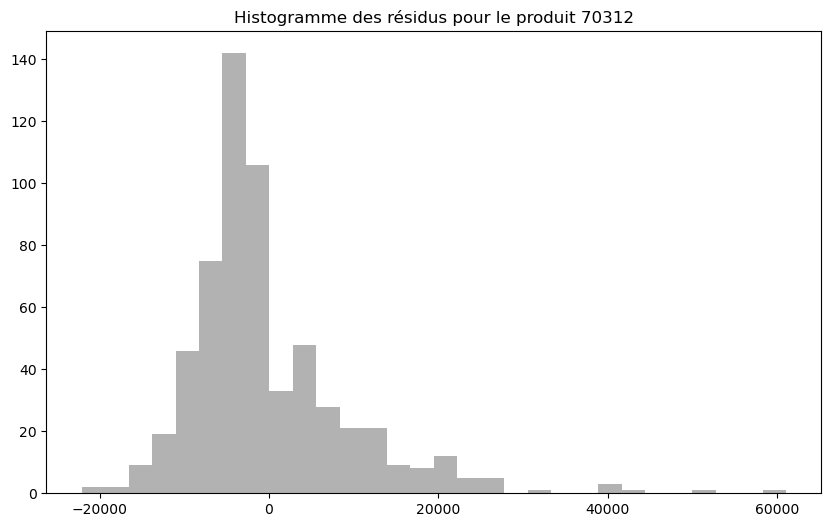

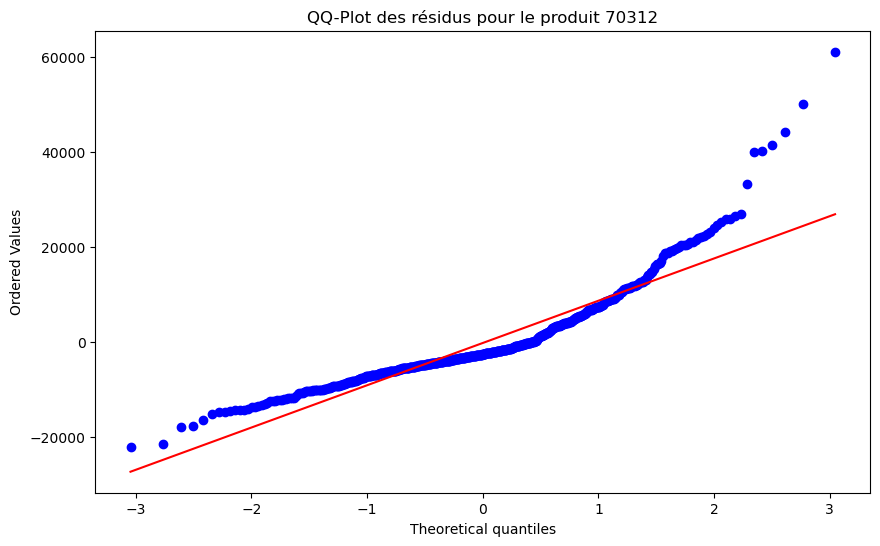

Normalité des résidus pour 70312: Statistique=20.86724896628084, p-value=0.0
Ljung-Box pour 70312: Statistiques=lb_stat, p-value=lb_pvalue


C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


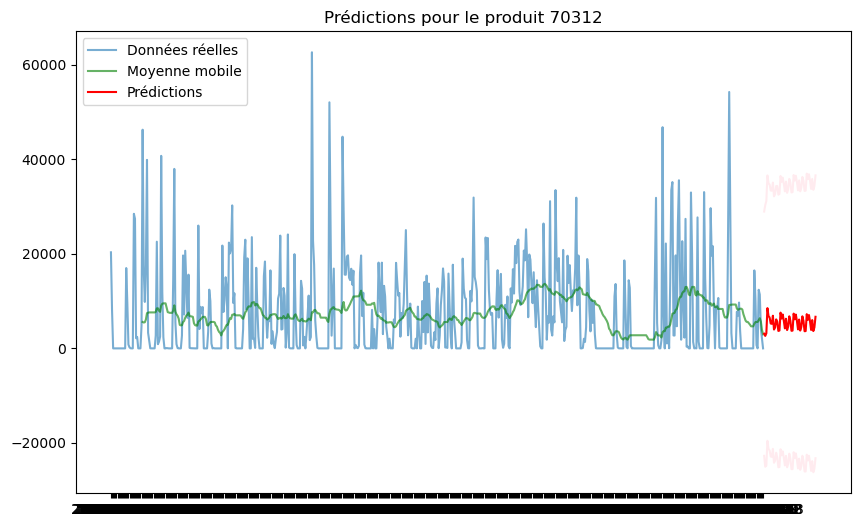

C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


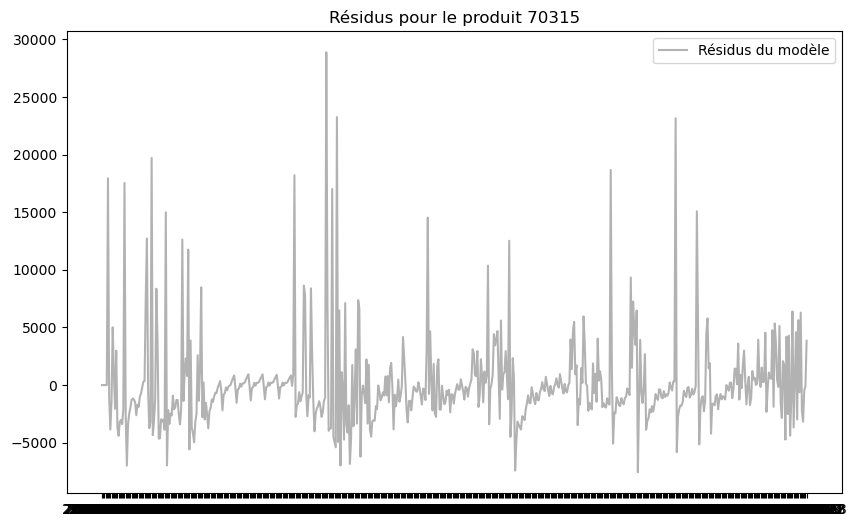

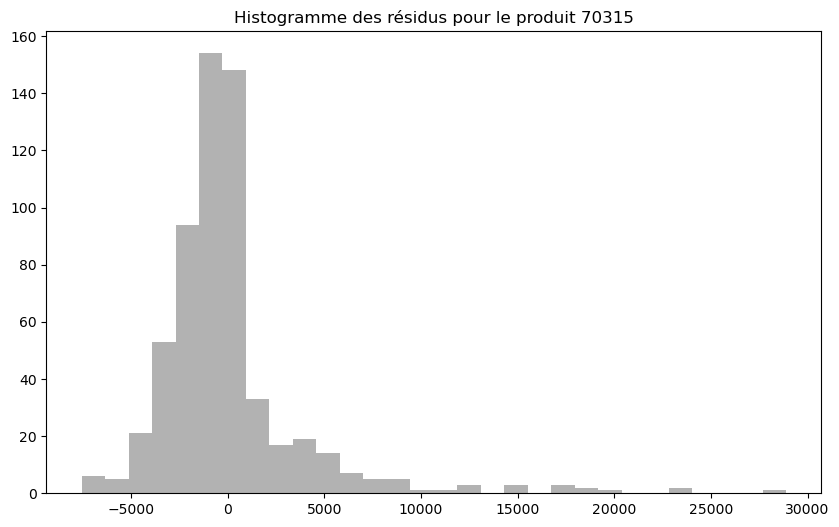

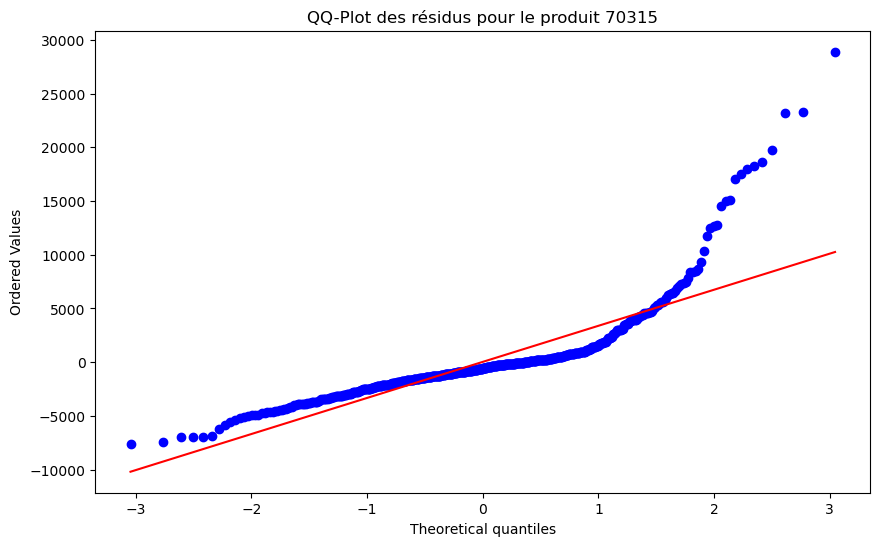

Normalité des résidus pour 70315: Statistique=39.59358736398076, p-value=0.0
Ljung-Box pour 70315: Statistiques=lb_stat, p-value=lb_pvalue


C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


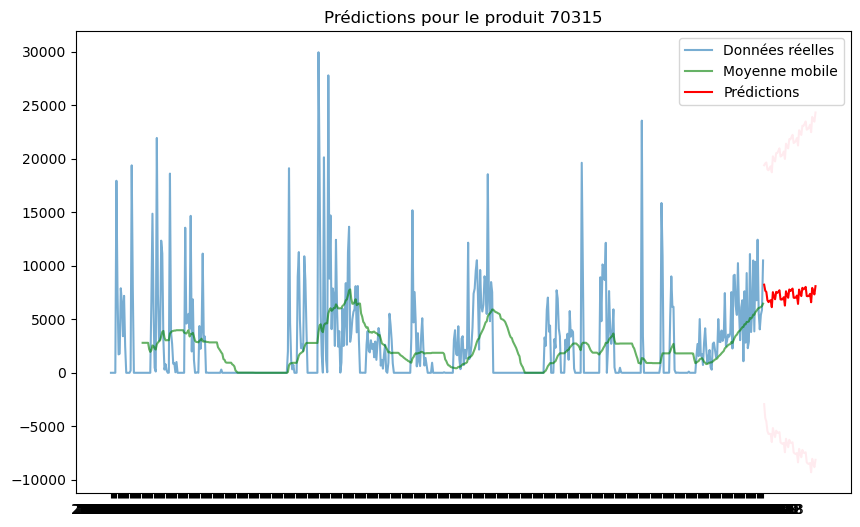

C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


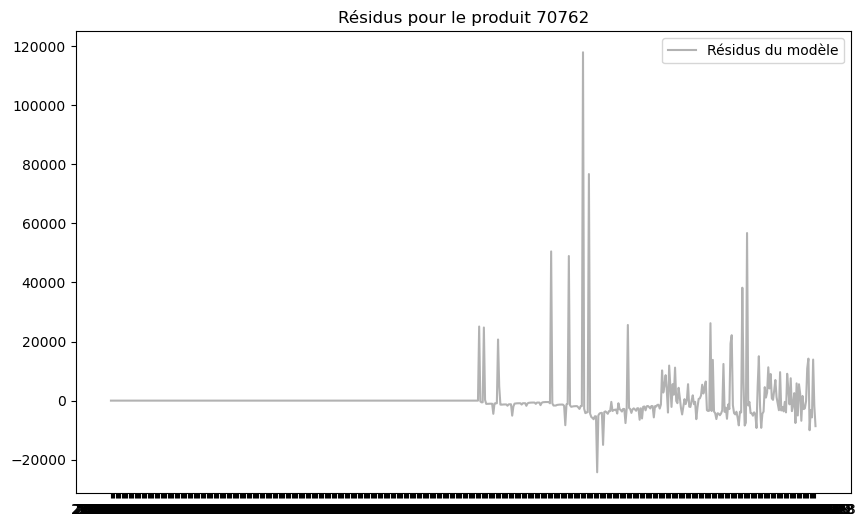

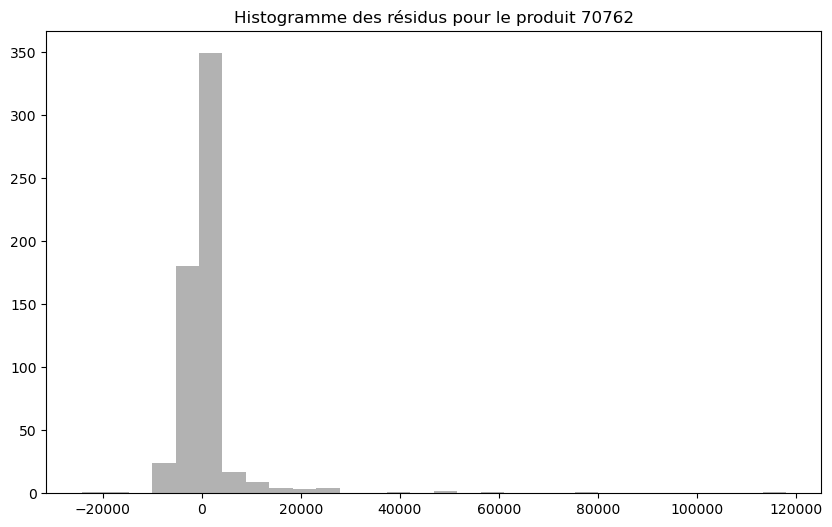

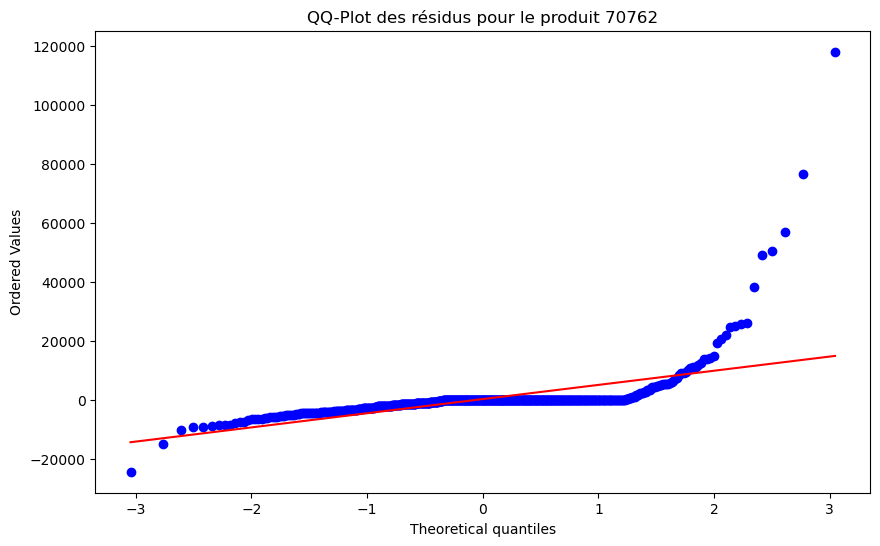

Normalité des résidus pour 70762: Statistique=inf, p-value=0.0
Ljung-Box pour 70762: Statistiques=lb_stat, p-value=lb_pvalue


C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


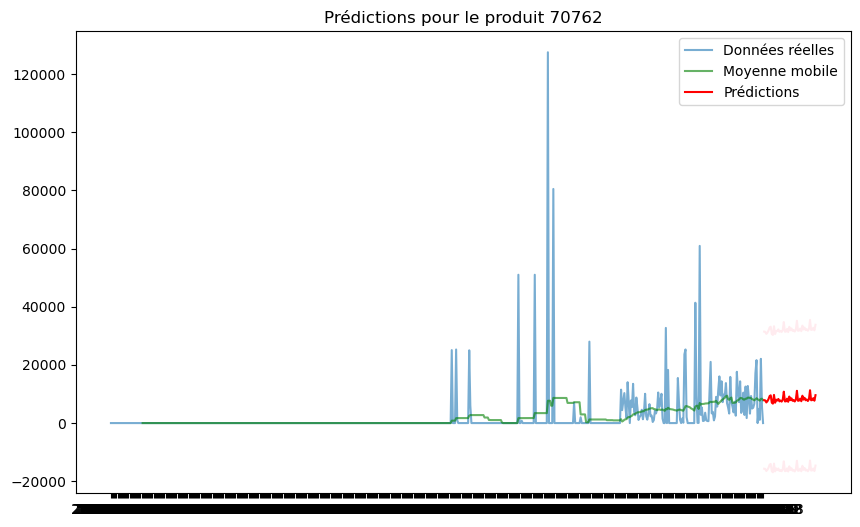

C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


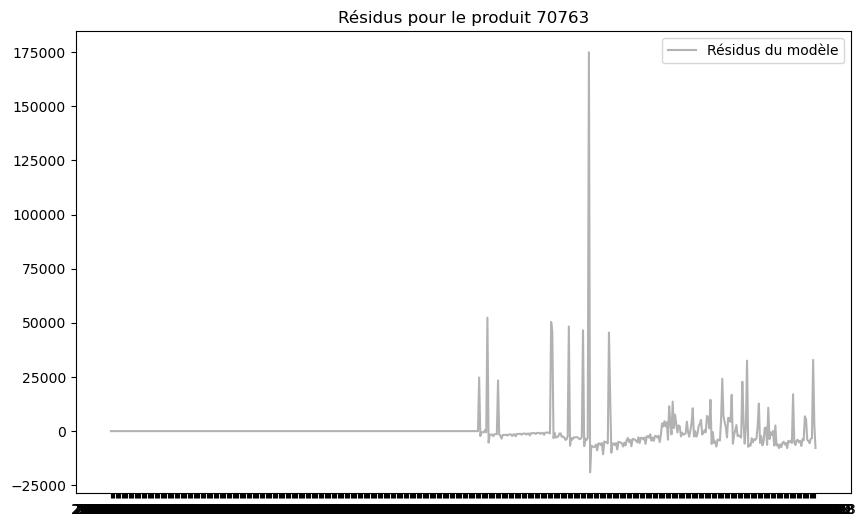

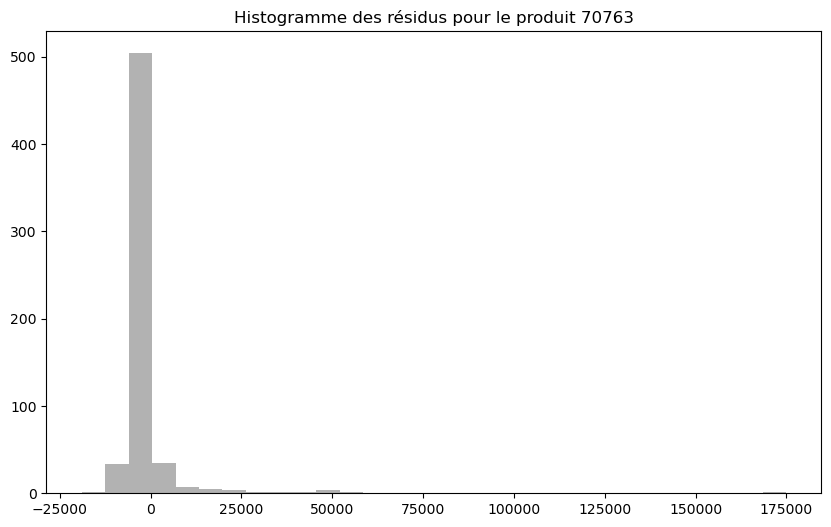

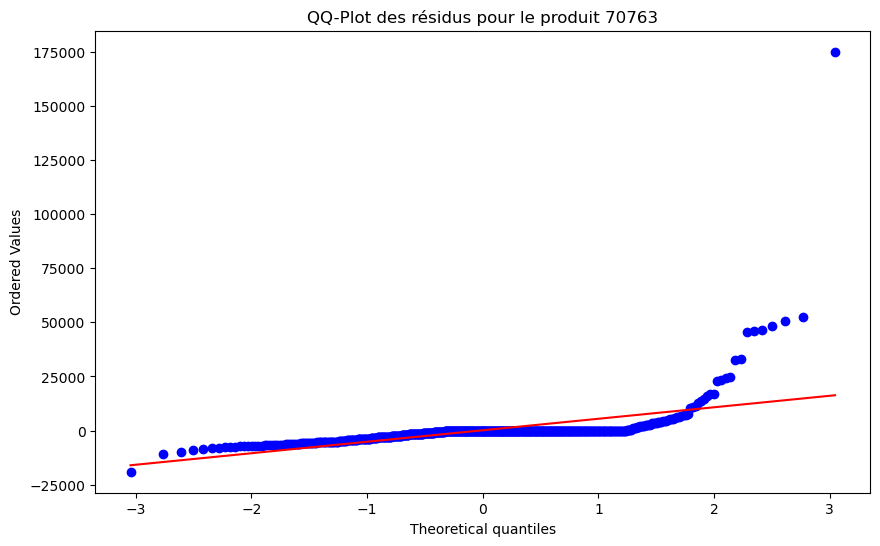

Normalité des résidus pour 70763: Statistique=inf, p-value=0.0
Ljung-Box pour 70763: Statistiques=lb_stat, p-value=lb_pvalue


C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


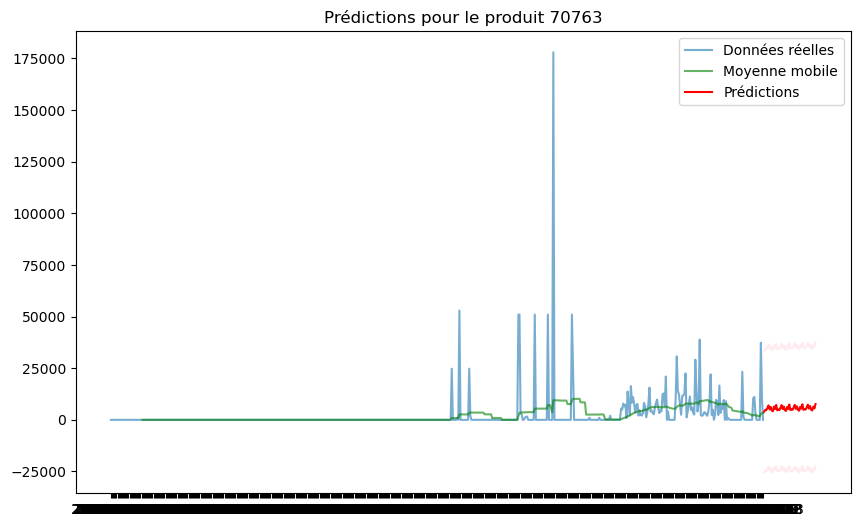

C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


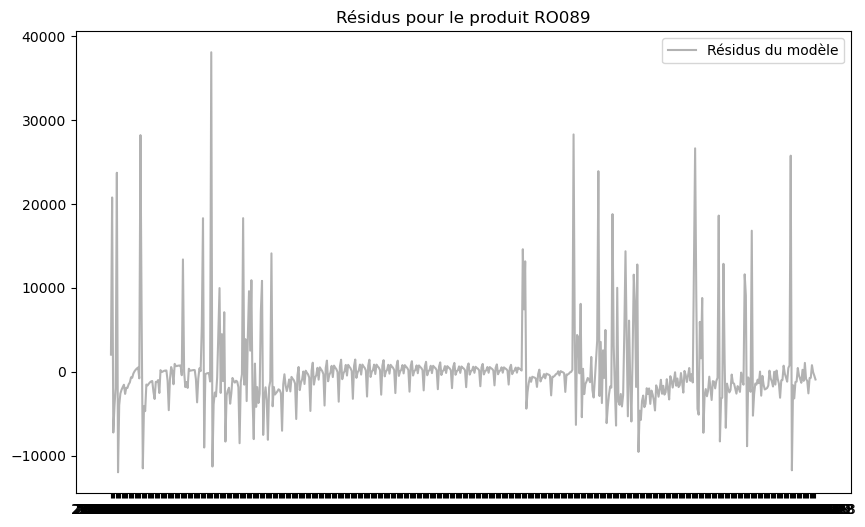

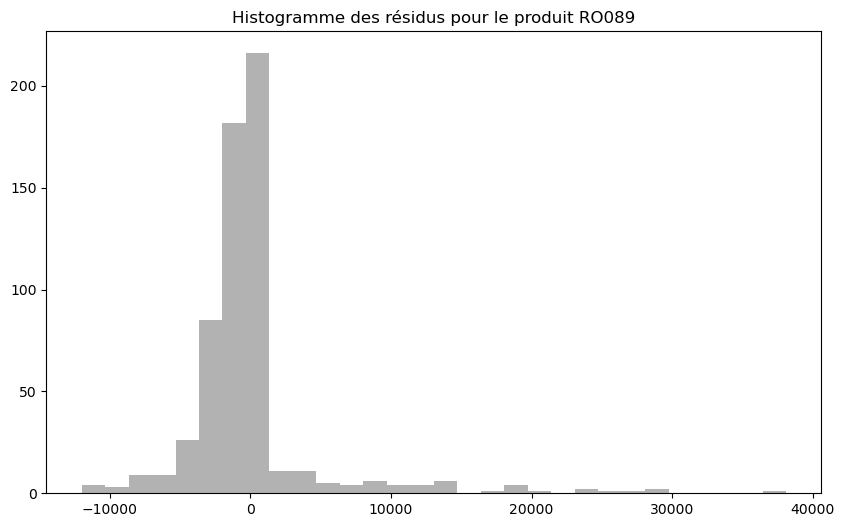

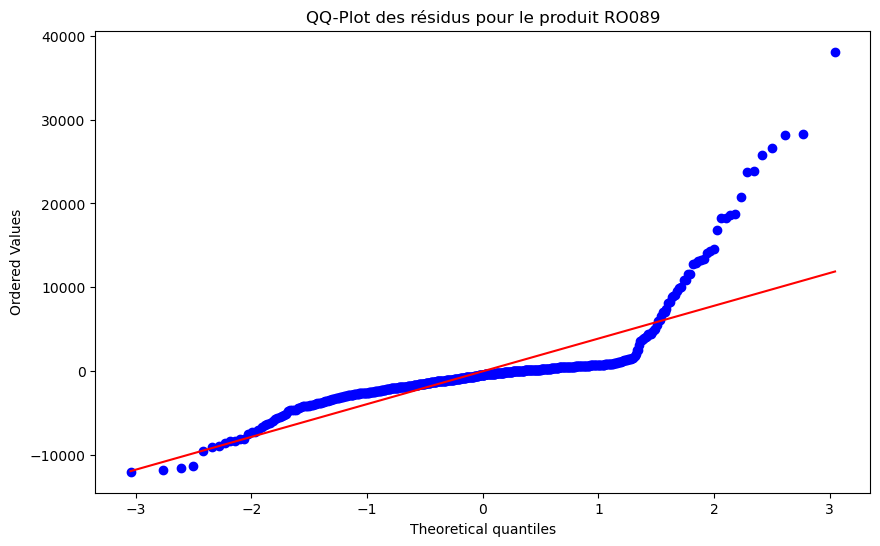

Normalité des résidus pour RO089: Statistique=62.69993904667399, p-value=0.0
Ljung-Box pour RO089: Statistiques=lb_stat, p-value=lb_pvalue


C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


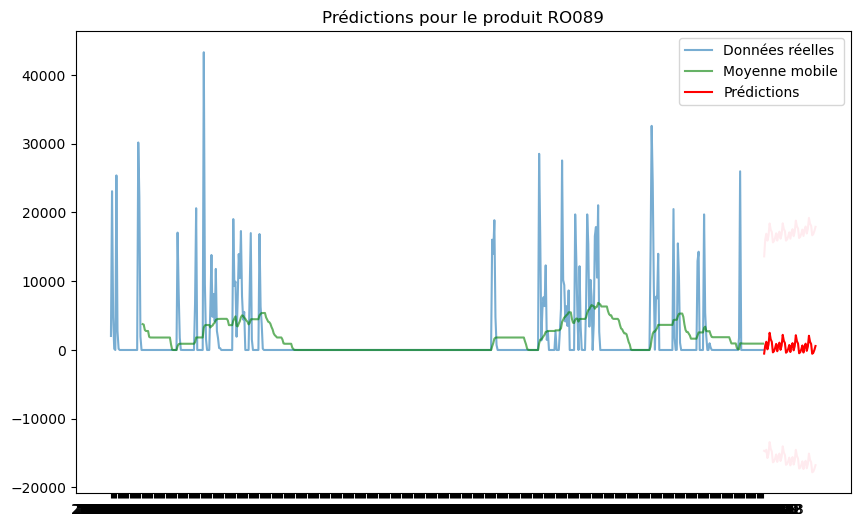

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox, normal_ad
import scipy.stats as stats

# Liste des produits
produits = df_filtered_pivot.columns

# Boucle pour chaque produit
for produit in produits:
    # Extraire la série temporelle pour ce produit
    serie = df_filtered_pivot[produit].dropna()  # Enlever les valeurs manquantes si nécessaire
    
    # Appliquer la moyenne mobile sur les données réelles
    serie_smoothed = serie.rolling(window=30).mean()
    
    # Ajuster un modèle SARIMAX
    model = SARIMAX(serie, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), enforce_stationarity=False, enforce_invertibility=False)
    result = model.fit(disp=False)
    
    # Résidus du modèle
    residuals = result.resid
    
    # Tracer les résidus
    plt.figure(figsize=(10, 6))
    plt.plot(residuals, label='Résidus du modèle', color='gray', alpha=0.6)
    plt.title(f"Résidus pour le produit {produit}")
    plt.legend()
    plt.show()
    
    # Histogramme des résidus
    plt.figure(figsize=(10, 6))
    plt.hist(residuals, bins=30, alpha=0.6, color='gray')
    plt.title(f"Histogramme des résidus pour le produit {produit}")
    plt.show()

    # QQ-Plot des résidus
    plt.figure(figsize=(10, 6))
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title(f"QQ-Plot des résidus pour le produit {produit}")
    plt.show()
    
    # Test de normalité des résidus
    normal_test = normal_ad(residuals)
    print(f"Normalité des résidus pour {produit}: Statistique={normal_test[0]}, p-value={normal_test[1]}")
    
    # Test de Ljung-Box pour les résidus
    lb_stat, lb_p_value = acorr_ljungbox(residuals, lags=12)
    print(f"Ljung-Box pour {produit}: Statistiques={lb_stat}, p-value={lb_p_value}")
    
    # Prédiction sur les 12 prochains mois
    forecast = result.get_forecast(steps=48)
    forecast_mean = forecast.predicted_mean
    forecast_ci = forecast.conf_int()
    
    # Appliquer la moyenne mobile sur les prévisions
    forecast_smoothed = forecast_mean.rolling(window=30).mean()

    # Tracer les résultats
    plt.figure(figsize=(10, 6))
    
    # Tracer les données réelles et leur moyenne mobile
    plt.plot(serie, label='Données réelles', alpha=0.6)
    plt.plot(serie_smoothed, label='Moyenne mobile', color='green', alpha=0.6)
    
    # Tracer les prévisions et l'intervalle de confiance
    plt.plot(forecast_mean, label='Prédictions', color='red')
    plt.plot(forecast_ci.index, forecast_ci.iloc[:, 0], color='pink', alpha=0.3)  # Intervalle de confiance
    plt.plot(forecast_ci.index, forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
    
    plt.title(f"Prédictions pour le produit {produit}")
    plt.legend()
    plt.show()


C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_

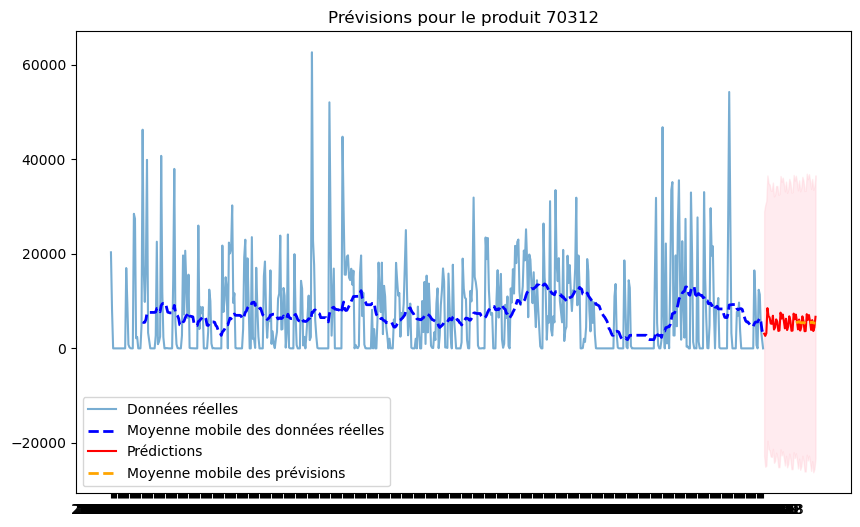

C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_

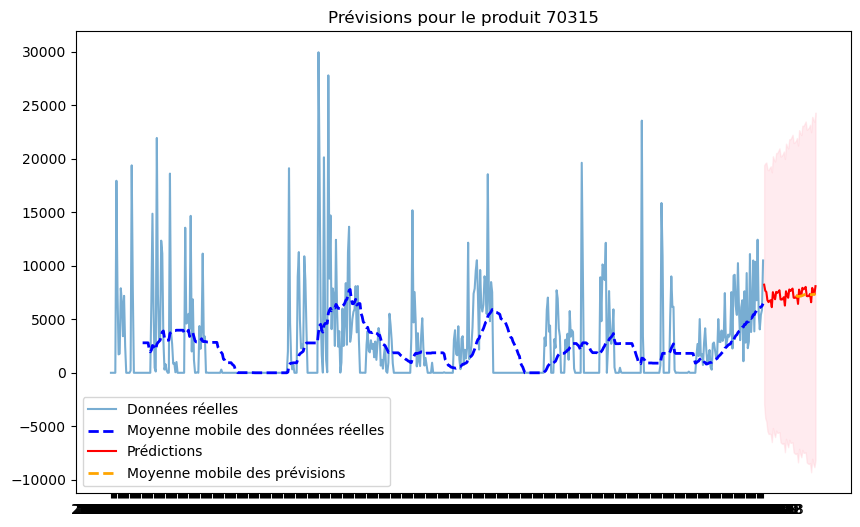

C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_

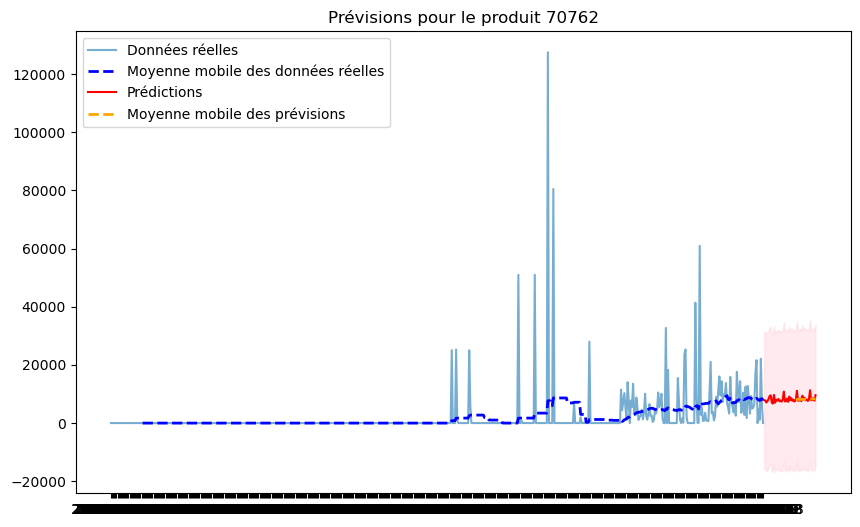

C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_

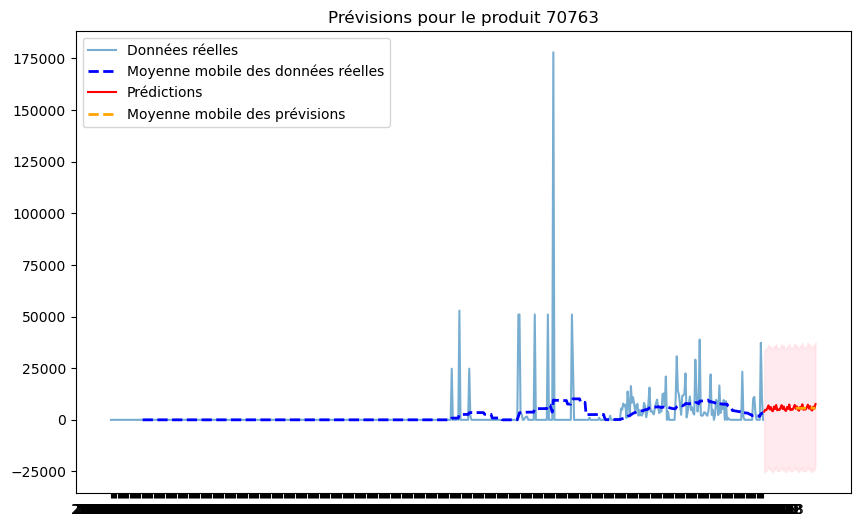

C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_

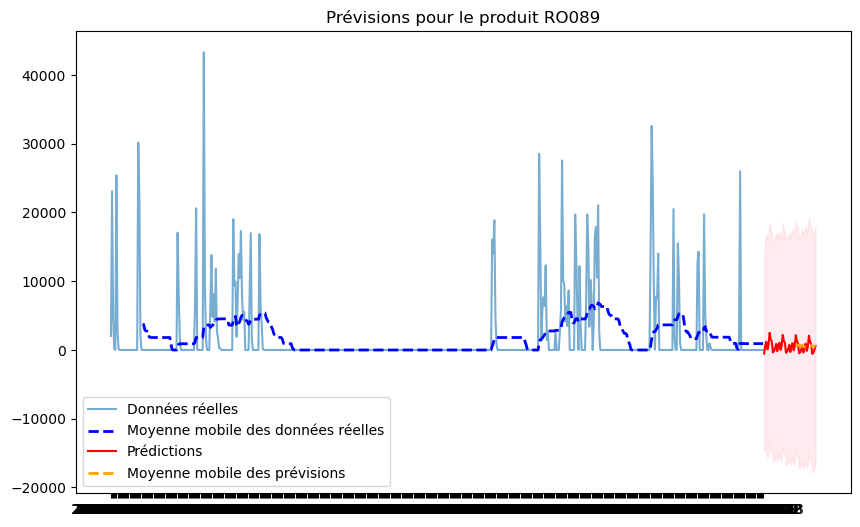

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Liste des produits
produits = df_filtered_pivot.columns

# Boucle pour chaque produit
for produit in produits:
    # Extraire la série temporelle pour ce produit
    serie = df_filtered_pivot[produit].dropna()  # Enlever les valeurs manquantes si nécessaire
    
    # Appliquer la moyenne mobile sur les données réelles
    serie_smoothed = serie.rolling(window=30).mean()
    
    # Ajuster un modèle SARIMAX
    model = SARIMAX(serie, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), enforce_stationarity=False, enforce_invertibility=False)
    result = model.fit(disp=False)
    
    # Prédiction sur les 12 prochains mois
    forecast = result.get_forecast(steps=48)
    forecast_mean = forecast.predicted_mean
    forecast_ci = forecast.conf_int()
    
    # Appliquer la moyenne mobile sur les prévisions
    forecast_smoothed = forecast_mean.rolling(window=30).mean()

    # Tracer les résultats
    plt.figure(figsize=(10, 6))
    
    # Tracer les données réelles et leur moyenne mobile
    plt.plot(serie, label='Données réelles', alpha=0.6)
    plt.plot(serie_smoothed, label='Moyenne mobile des données réelles', color='blue', linestyle='--', linewidth=2)
    
    # Tracer les prévisions et leur moyenne mobile
    plt.plot(forecast_mean, color='red', label='Prédictions')
    plt.plot(forecast_smoothed, color='orange', label='Moyenne mobile des prévisions', linestyle='--', linewidth=2)
    
    # Ajouter l'intervalle de confiance des prévisions
    plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
    
    # Personnaliser le graphique
    plt.title(f"Prévisions pour le produit {produit}")
    plt.legend()
    plt.show()
